# Setup

In [25]:
import os
import warnings

import numpy as np
from matplotlib import pyplot as plt

from compare_variance_residual.simulated.plotting import plot_experiment
from compare_variance_residual.simulated.simulation import run_experiment

warnings.simplefilter(action='ignore')
plt.style.use('ggplot')

In [26]:
from himalaya.backend import set_backend

backend = set_backend("cupy", on_error="warn")

In [27]:
def get_results(variable_name, variable_values, overwrite=False, **variables):
    experiment_dir = get_experiment_dir(variable_name, **variables)

    variance_filename = "variance.npy"
    residual_filename = "residual.npy"
    variance_path = os.path.join(experiment_dir, variance_filename)
    residual_path = os.path.join(experiment_dir, residual_filename)

    if overwrite or not os.path.exists(variance_path) or not os.path.exists(residual_path):
        if not os.path.exists(experiment_dir):
            os.makedirs(experiment_dir)
        predicted_variance, predicted_residual = run_experiment(variable_name, variable_values, **variables)
        np.save(variance_path, predicted_variance)
        np.save(residual_path, predicted_residual)
    else:
        predicted_variance = np.load(variance_path, allow_pickle=True)
        predicted_residual = np.load(residual_path, allow_pickle=True)
        # turn into python lists
        predicted_variance = predicted_variance.tolist()
        predicted_residual = predicted_residual.tolist()
    return predicted_variance, predicted_residual


def get_experiment_dir(variable_name, **variables):
    result_dir = "./results"
    experiment_variables = "".join(
        ['{}={!r}'.format(k,
                          [
                              f"{i:.2f}" if isinstance(i, float) else i  # Handle floats in the list
                              for i in v
                          ] if isinstance(v, list)
                          else f"{v:.2f}" if isinstance(v, float) else v  # Handle floats not in lists
                          )
         for k, v in variables.items()])

    # replace illegal characters
    experiment_variables = experiment_variables.replace(" ", "")
    experiment_variables = experiment_variables.replace("[", "")
    experiment_variables = experiment_variables.replace("]", "")

    # cut filename, if it is too long
    if len(experiment_variables) > 255:
        experiment_variables = experiment_variables[:255]

    experiment_dir = os.path.join(result_dir, variable_name, experiment_variables)
    return experiment_dir

# Set default values to be used in the tests

In [28]:
n_observations = 3

variables = dict(
    # dataset
    n_runs=100,
    n_observations=n_observations,
    d_list=[100, 100, 100],
    scalars=[1 / 3, 1 / 3, 1 / 3],
    n_targets=100,
    n_samples_train=1000,
    n_samples_test=100,
    noise_level=0.1,
    construction_method="stack",
    random_distribution="normal",

    # method parameters
    direct_vp=False,
    ignore_negative_r2=False,
    use_ols=False,

    # ridge regression
    cv=5,
    alphas=np.logspace(-4, 4, 9),
)

# Varying distributions

In [29]:
variable_name = "sampling distribution"
random_distributions = [
    "normal",
    "uniform",
    "exponential",
    "gamma",
    "beta",
    "lognormal",
    "pareto"
]

In [30]:
predicted_variance, predicted_residual = get_results(variable_name, random_distributions, **variables)

[                                        ] 0% | 0.00 sec | Varying sampling distribution | 

KeyboardInterrupt: 

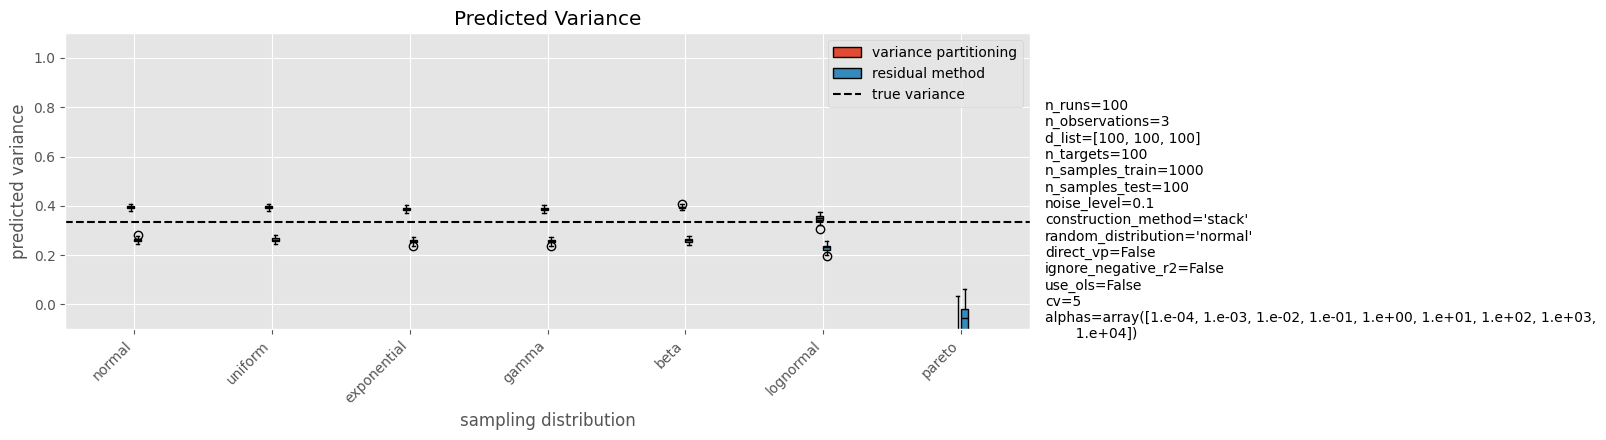

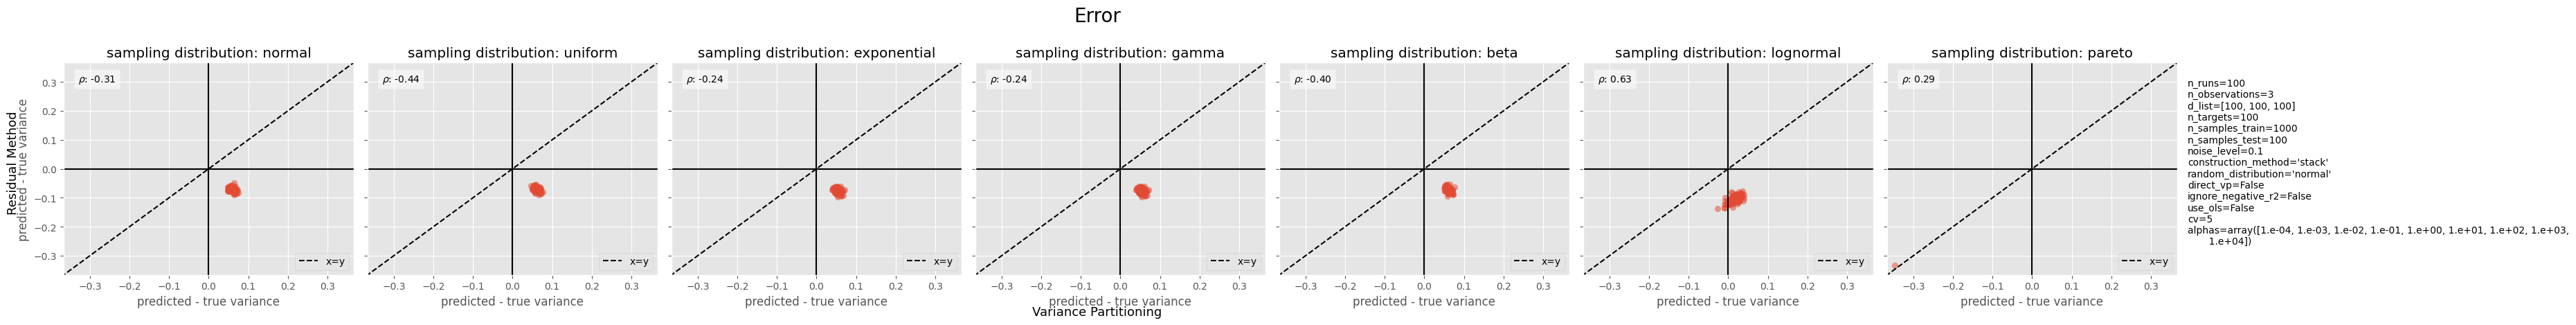

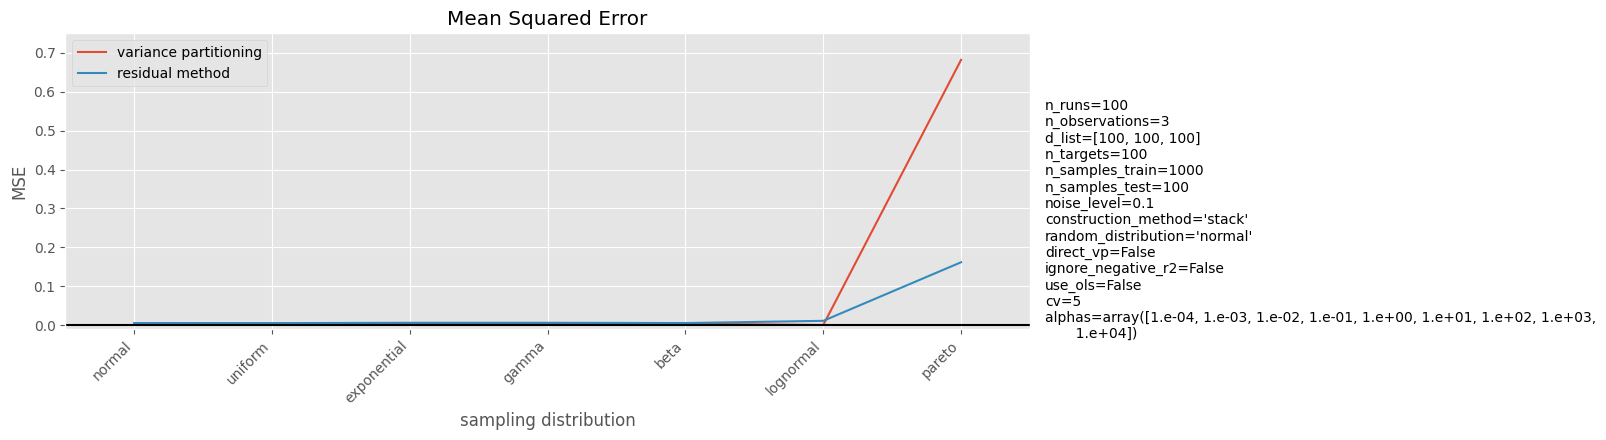

In [7]:
plot_experiment(variable_name, random_distributions, predicted_variance, predicted_residual,
                save_dir=get_experiment_dir(variable_name, **variables), **variables)

# Test varying sample sizes

## varying train sample sizes

In [8]:
mag = np.log10(variables["n_samples_train"])
sample_sizes_training = np.logspace(mag - 1, mag + 1, n_observations)
variable_name = "sample size training"

In [9]:
predicted_variance, predicted_residual = get_results(variable_name, sample_sizes_training, **variables)

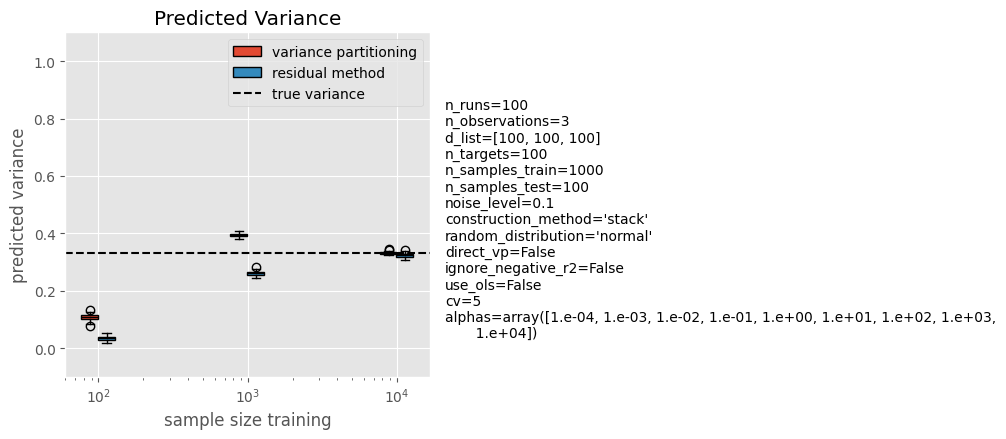

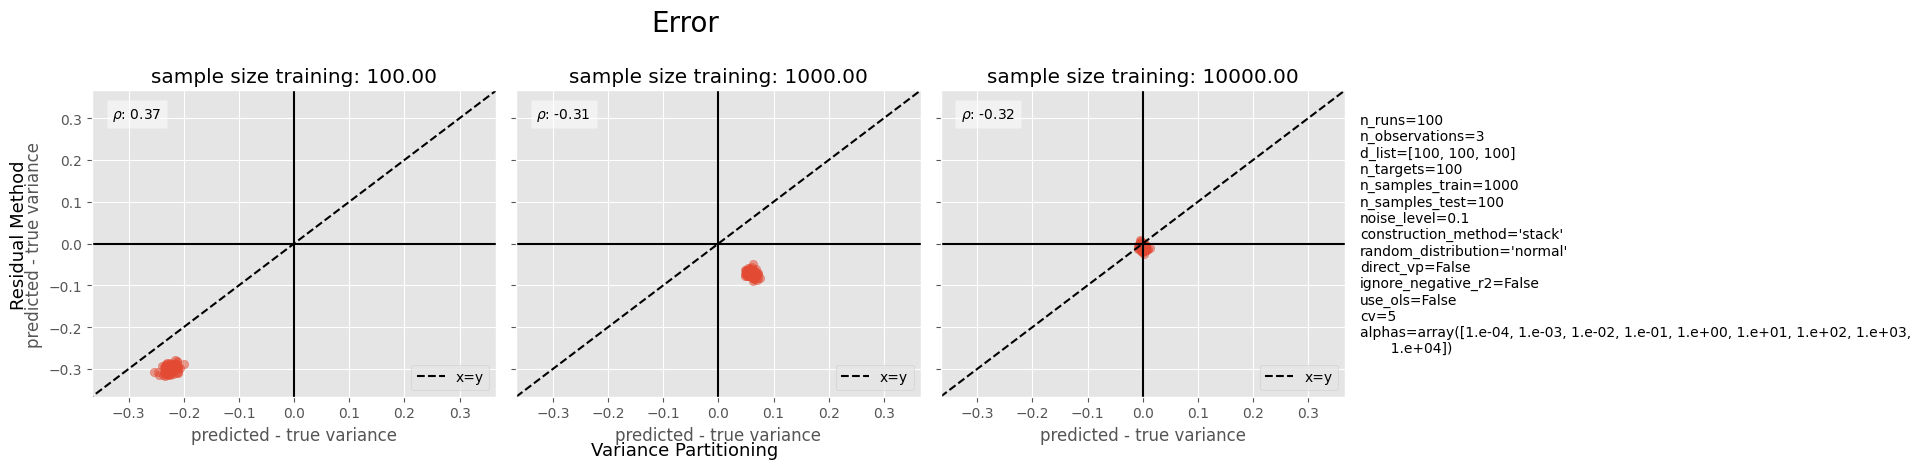

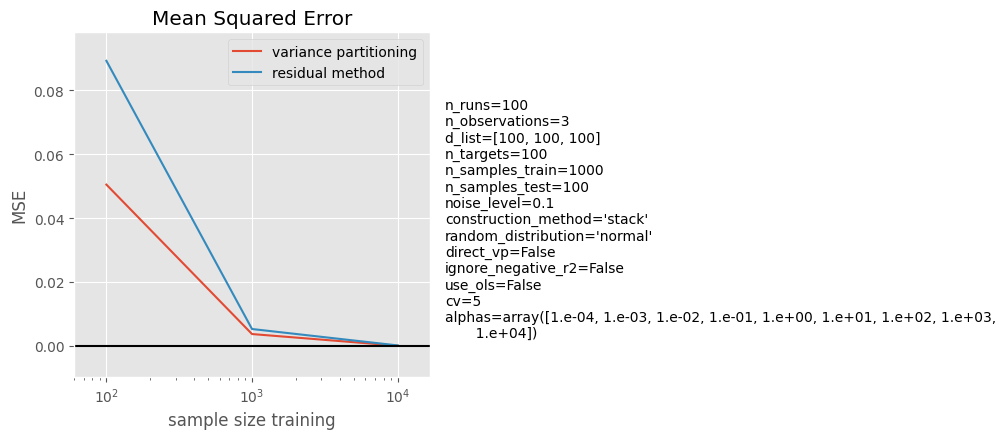

In [10]:
plot_experiment(variable_name, sample_sizes_training, predicted_variance, predicted_residual, x_is_log=True,
                save_dir=get_experiment_dir(variable_name, **variables),
                **variables)

## varying test sample sizes

In [11]:
mag = np.log10(variables["n_samples_test"])
sample_sizes_testing = np.logspace(mag - 1, mag + 1, n_observations)
variable_name = "sample size testing"

In [12]:
predicted_variance, predicted_residual = get_results(variable_name, sample_sizes_testing, **variables)

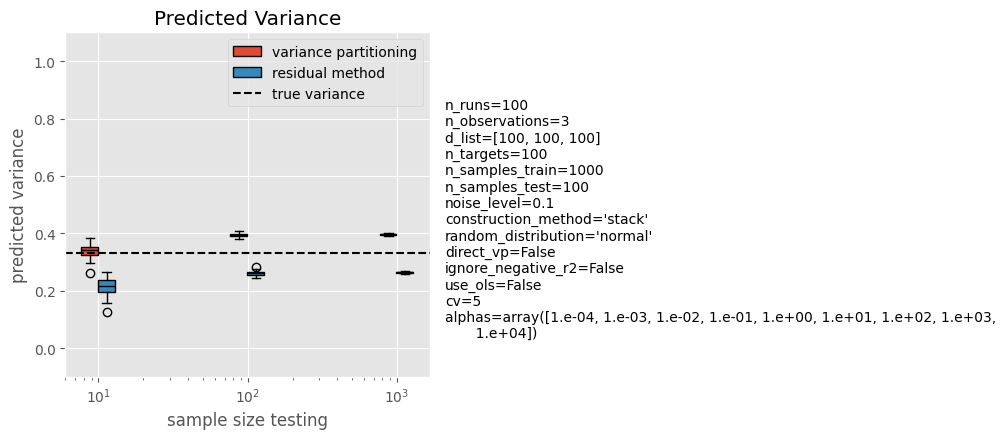

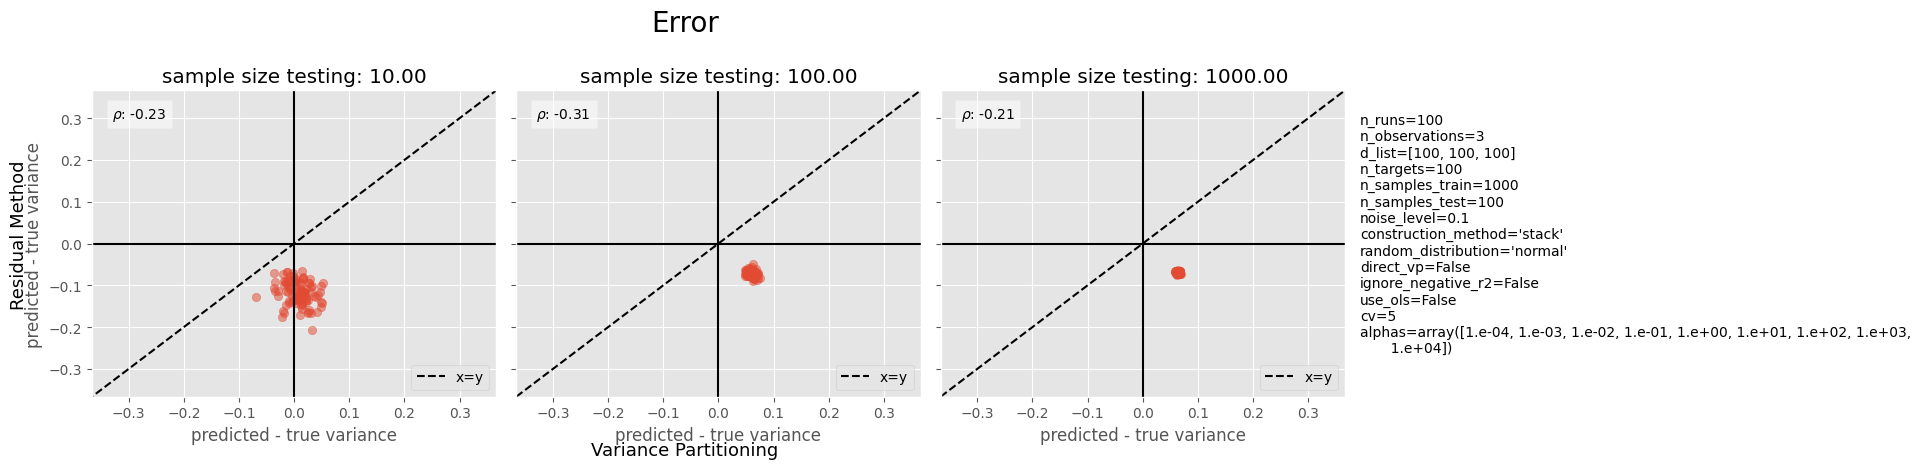

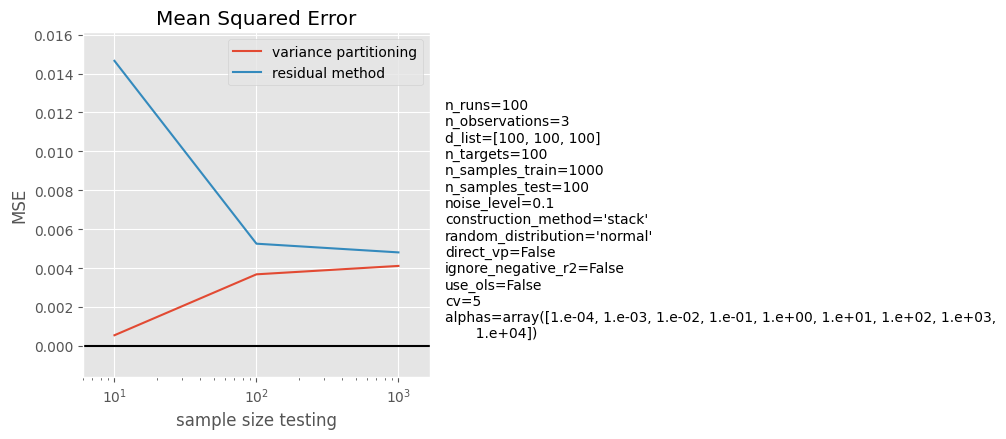

In [13]:
plot_experiment(variable_name, sample_sizes_testing, predicted_variance, predicted_residual, x_is_log=True,
                save_dir=get_experiment_dir(variable_name, **variables), **variables)

# Test varying feature sizes

In [14]:
mag = np.log10(variables["d_list"][0])
feature_sizes = np.logspace(mag - 1, mag + 1, n_observations)
variable_name = "number of features"

In [15]:
predicted_variance, predicted_residual = get_results(variable_name, feature_sizes, **variables)

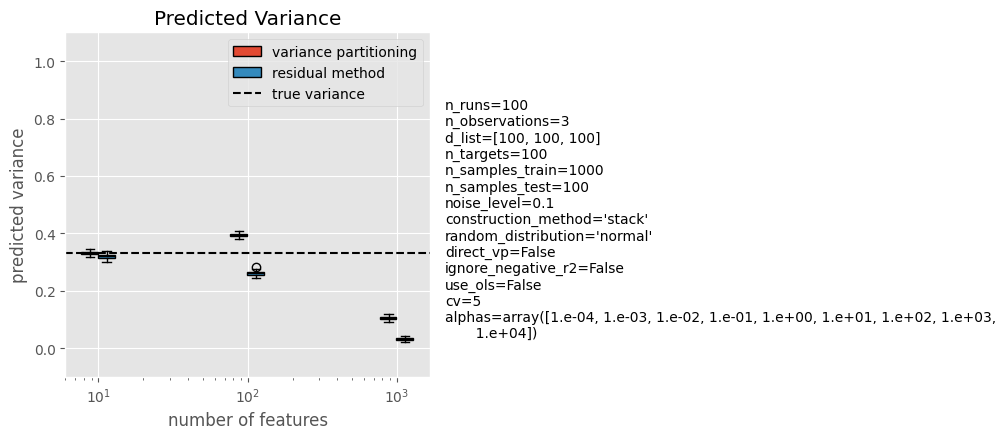

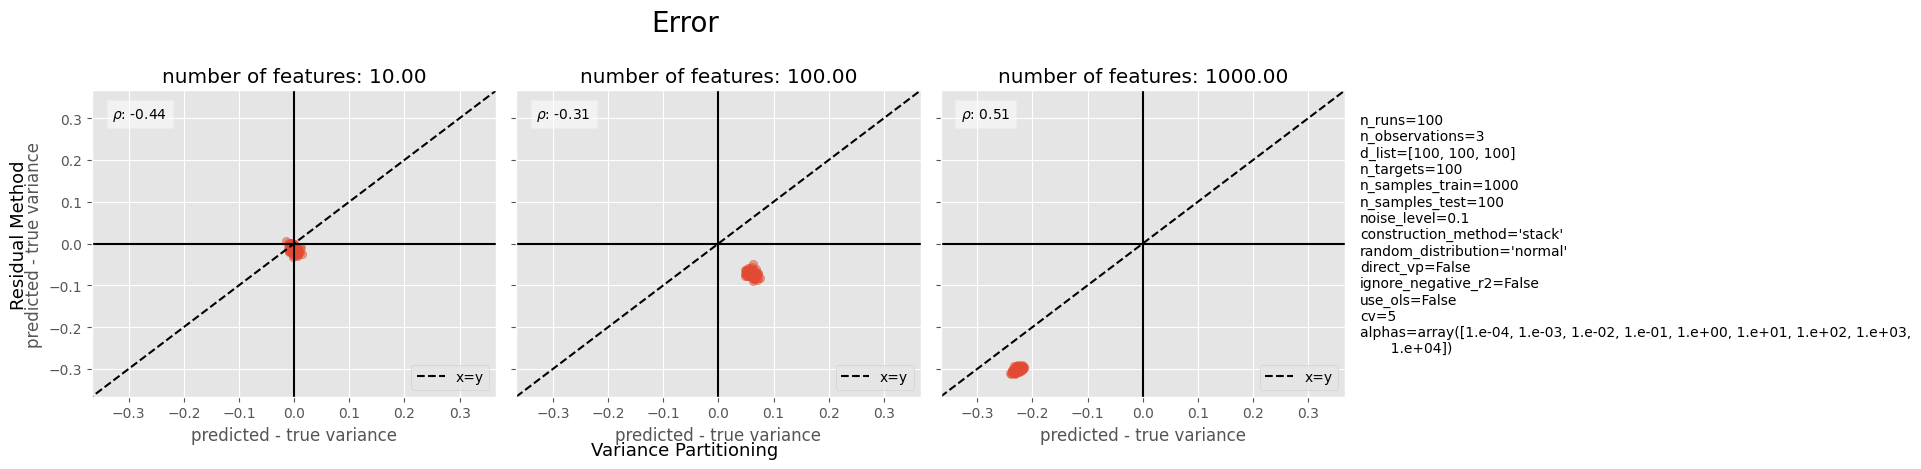

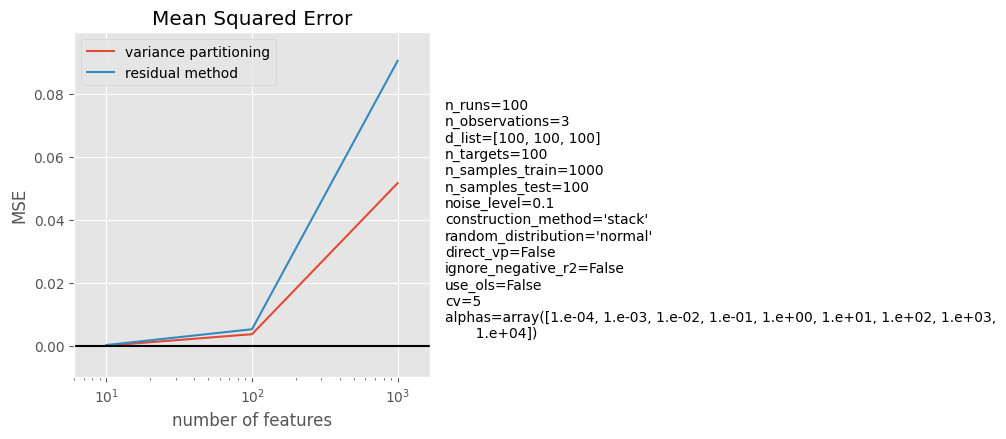

In [16]:
plot_experiment(variable_name, feature_sizes, predicted_variance, predicted_residual, x_is_log=True,
                save_dir=get_experiment_dir(variable_name, **variables), **variables)

# varying target size

In [17]:
variable_name = "number of targets"
mag = np.log10(variables["n_targets"])
target_sizes = np.logspace(mag - 1, mag + 1, n_observations)

In [18]:
predicted_variance, predicted_residual = get_results(variable_name, target_sizes, **variables)

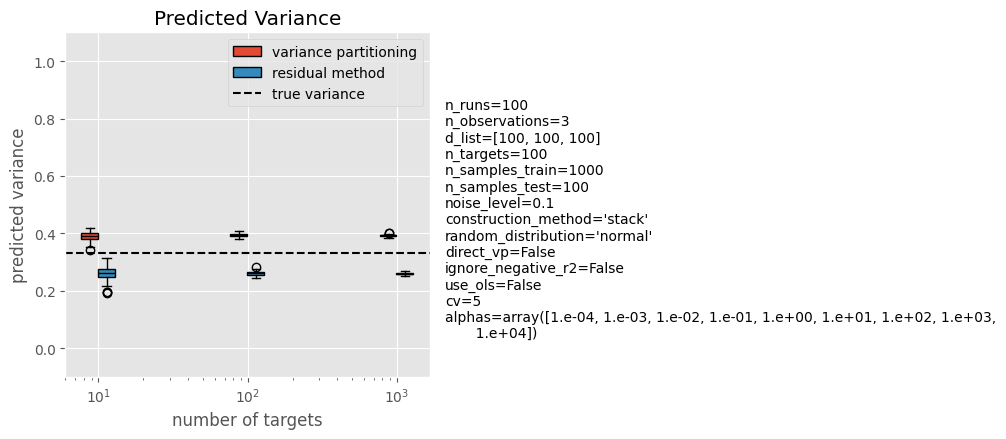

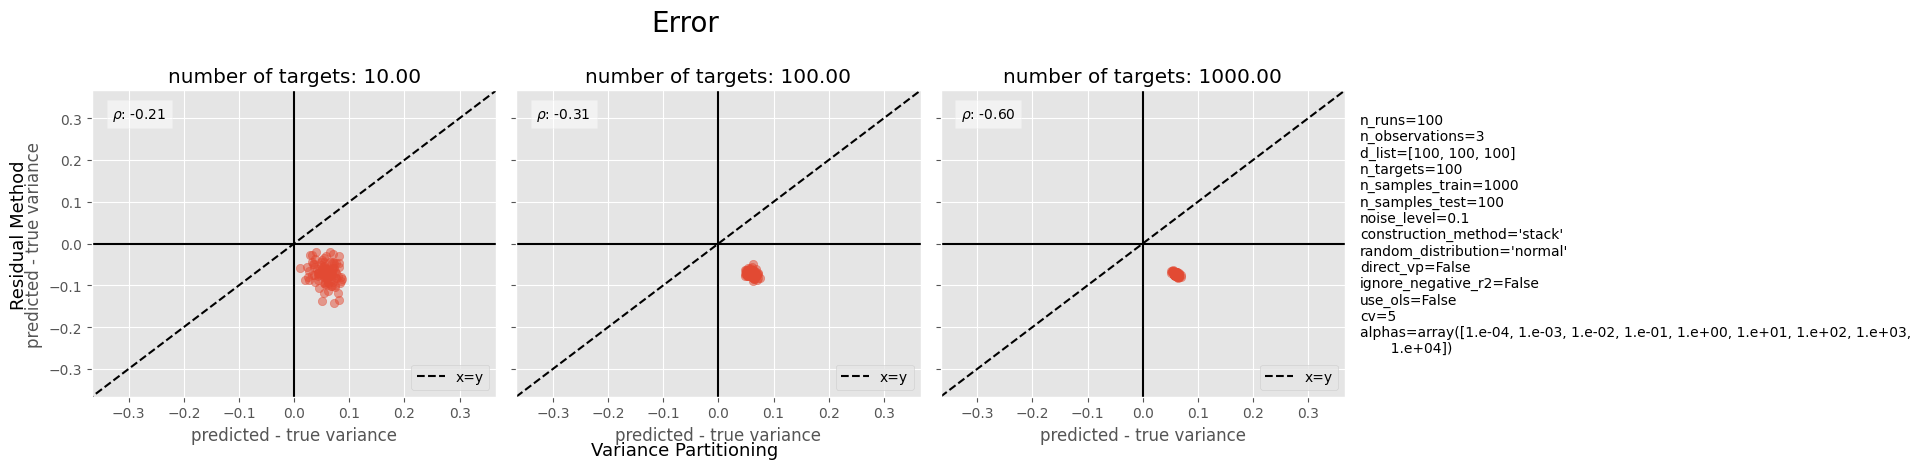

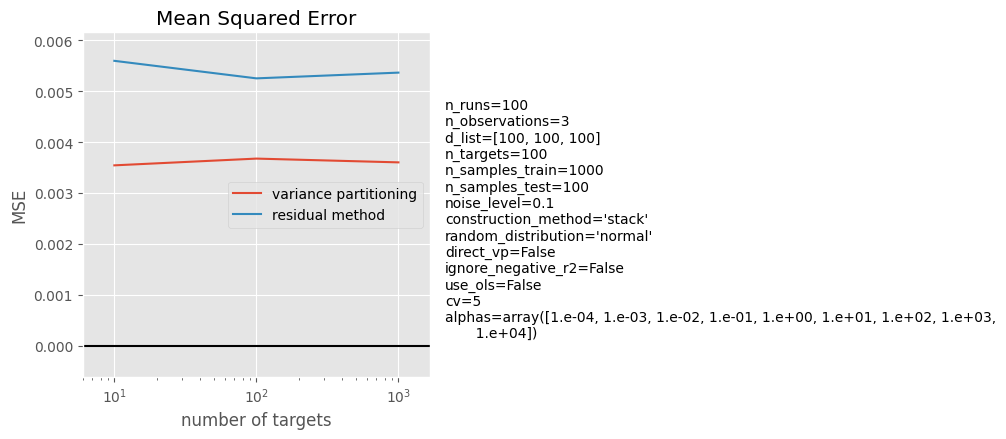

In [19]:
plot_experiment(variable_name, target_sizes, predicted_variance, predicted_residual, x_is_log=True,
                save_dir=get_experiment_dir(variable_name, **variables), **variables)

# Test varying noise levels

In [20]:
variable_name = "scalar amount of noise in the target"
noise_levels = np.linspace(0, 1, n_observations)

In [21]:
predicted_variance, predicted_residual = get_results(variable_name, noise_levels, **variables)

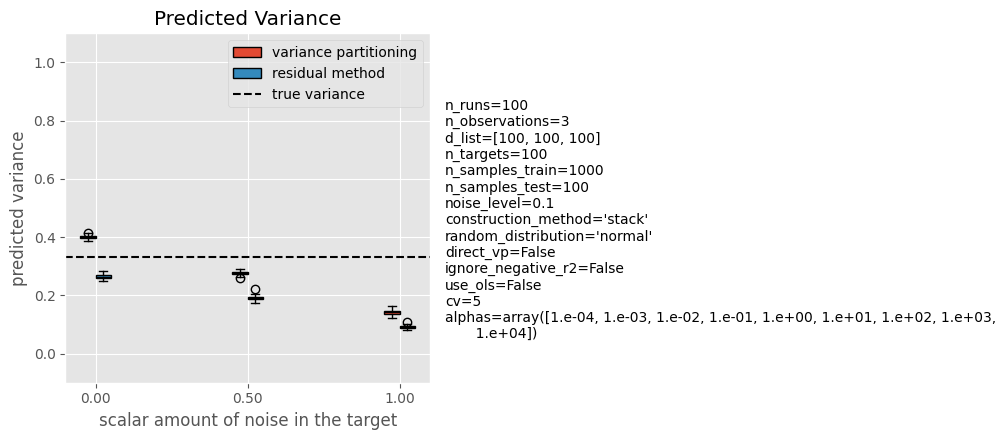

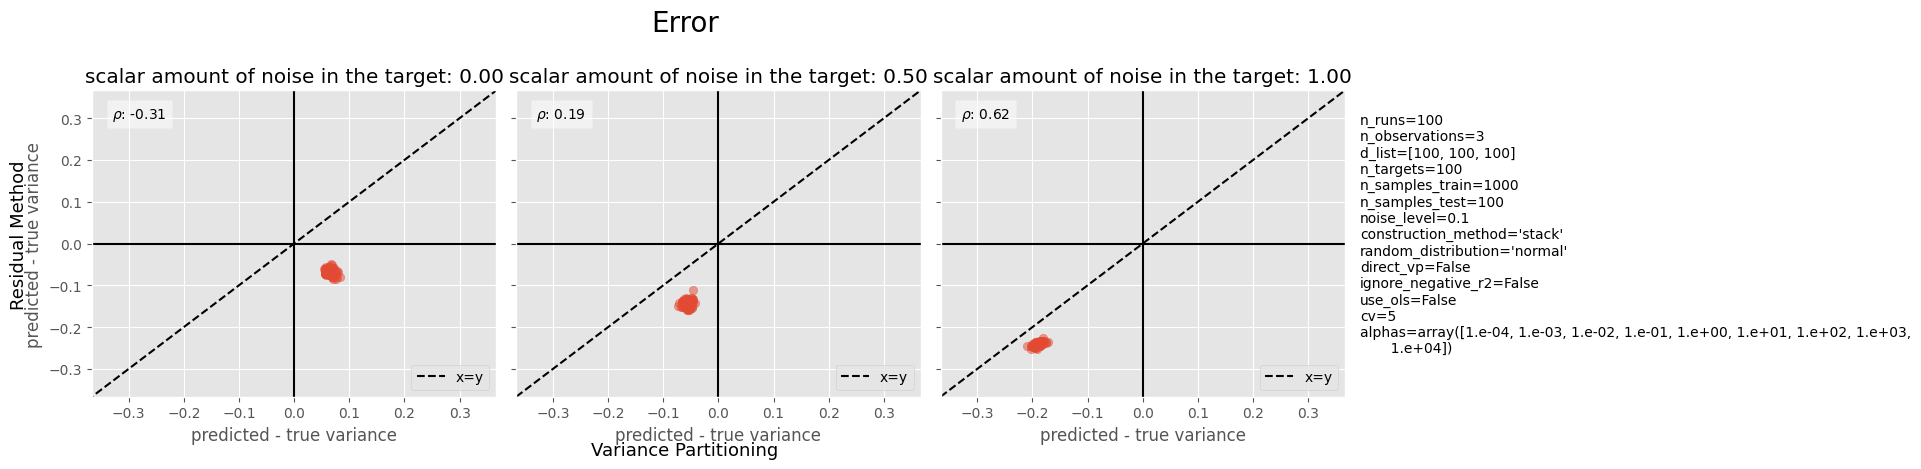

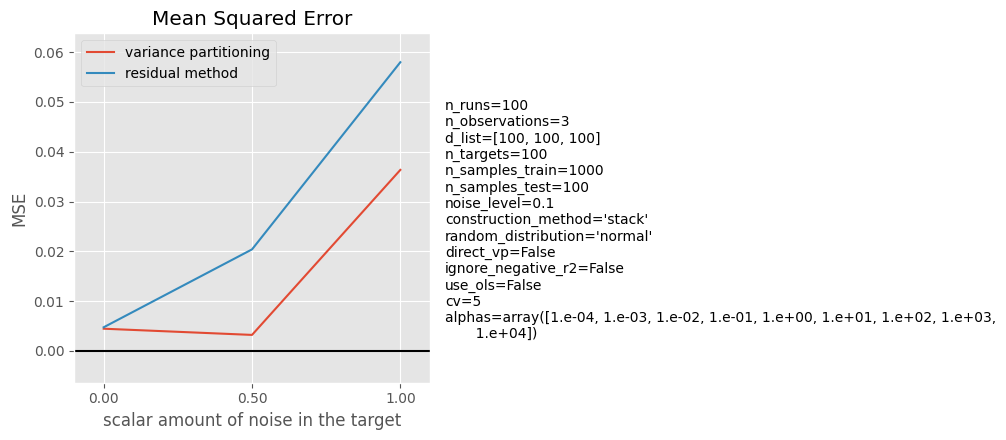

In [22]:
plot_experiment(variable_name, noise_levels, predicted_variance, predicted_residual,
                save_dir=get_experiment_dir(variable_name, **variables), **variables)

# Test varying unique variances of unique feature spaces

In [23]:
variable_name = "proportion of variance explained"
unique_variances = np.linspace(0, 1, n_observations)
# convert from np to python
unique_variances = [round(float(x), 2) for x in unique_variances]

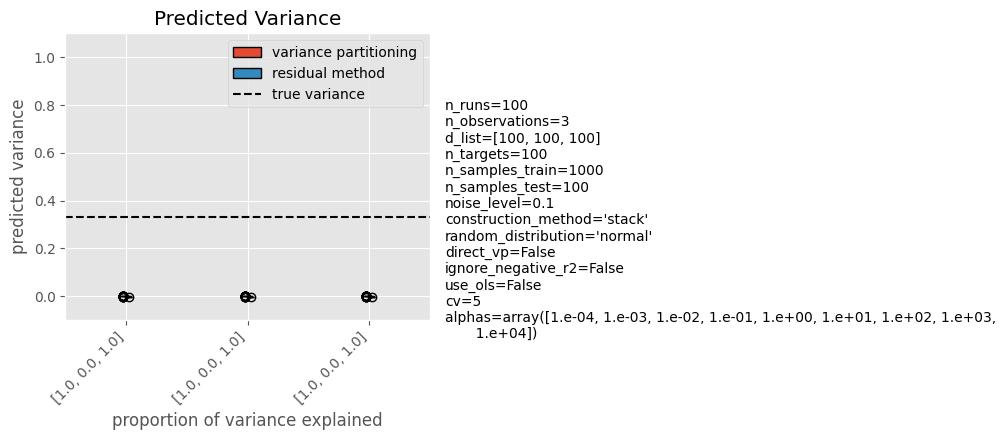

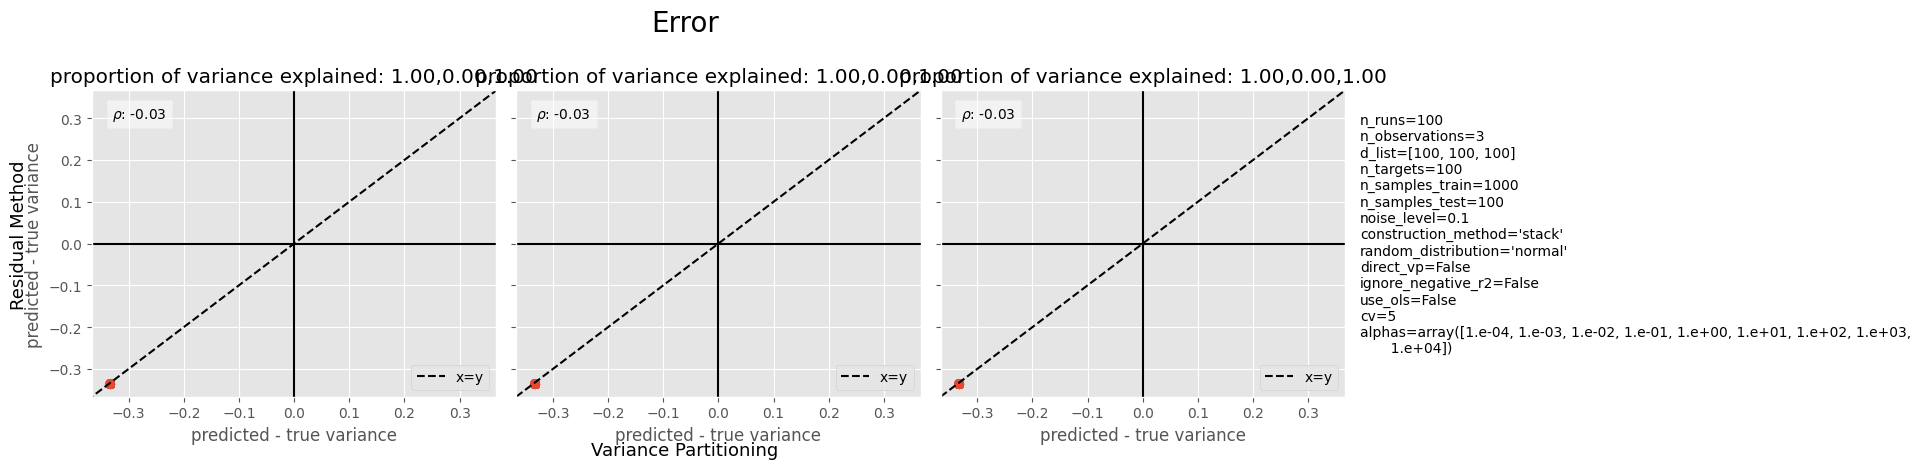

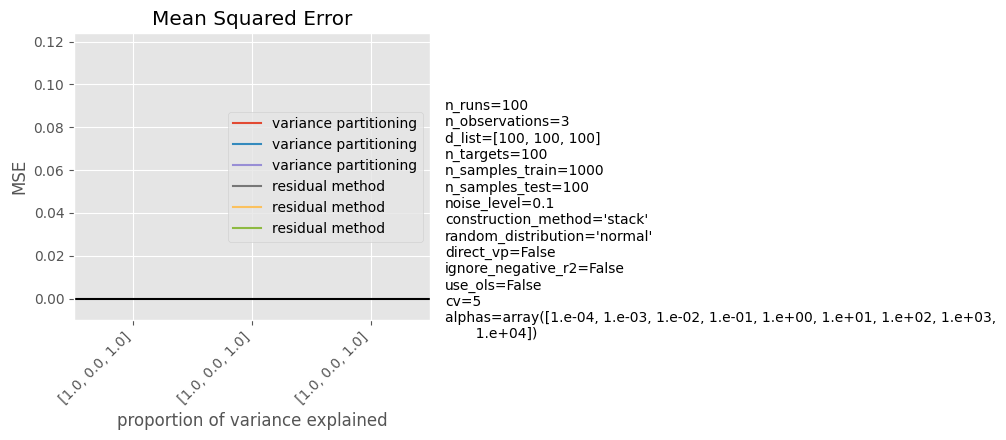

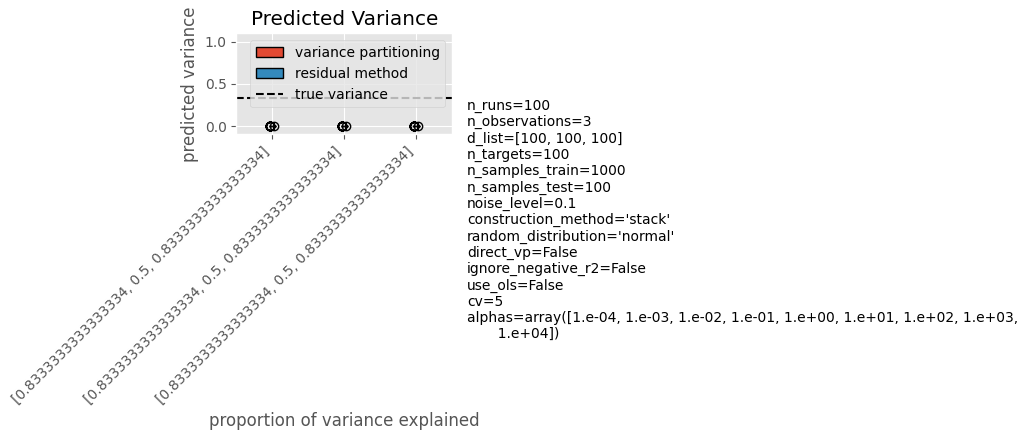

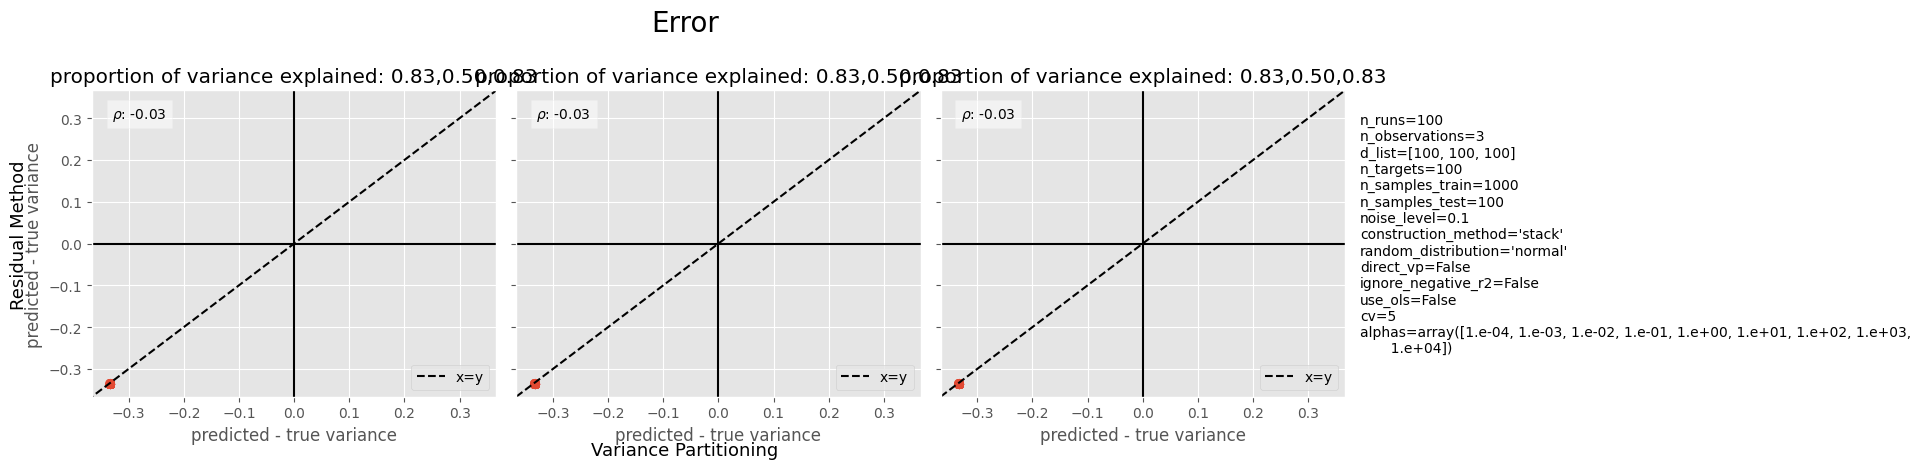

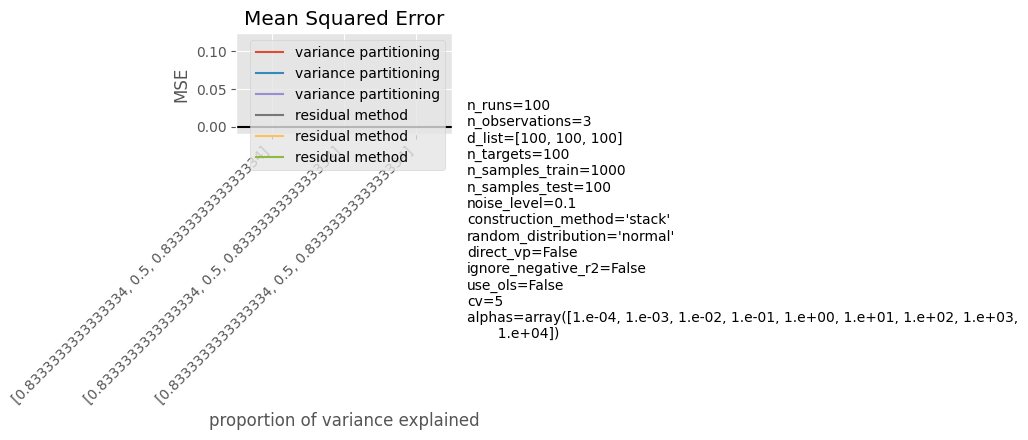

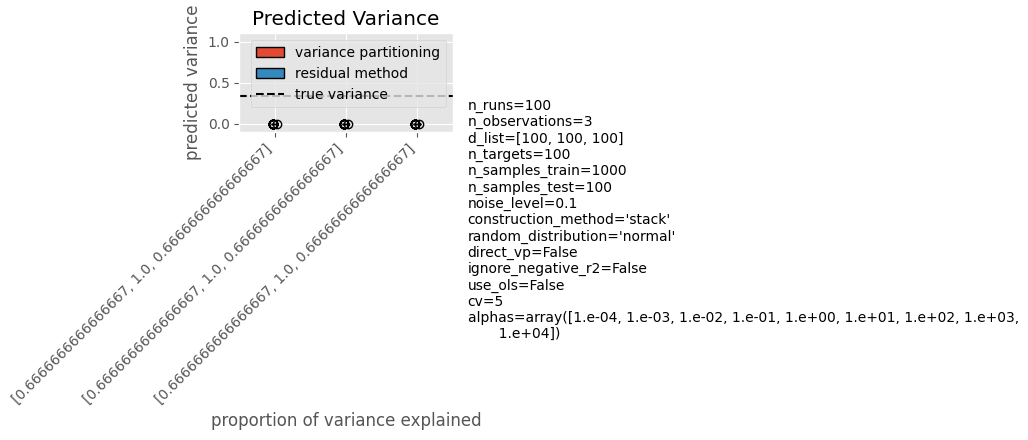

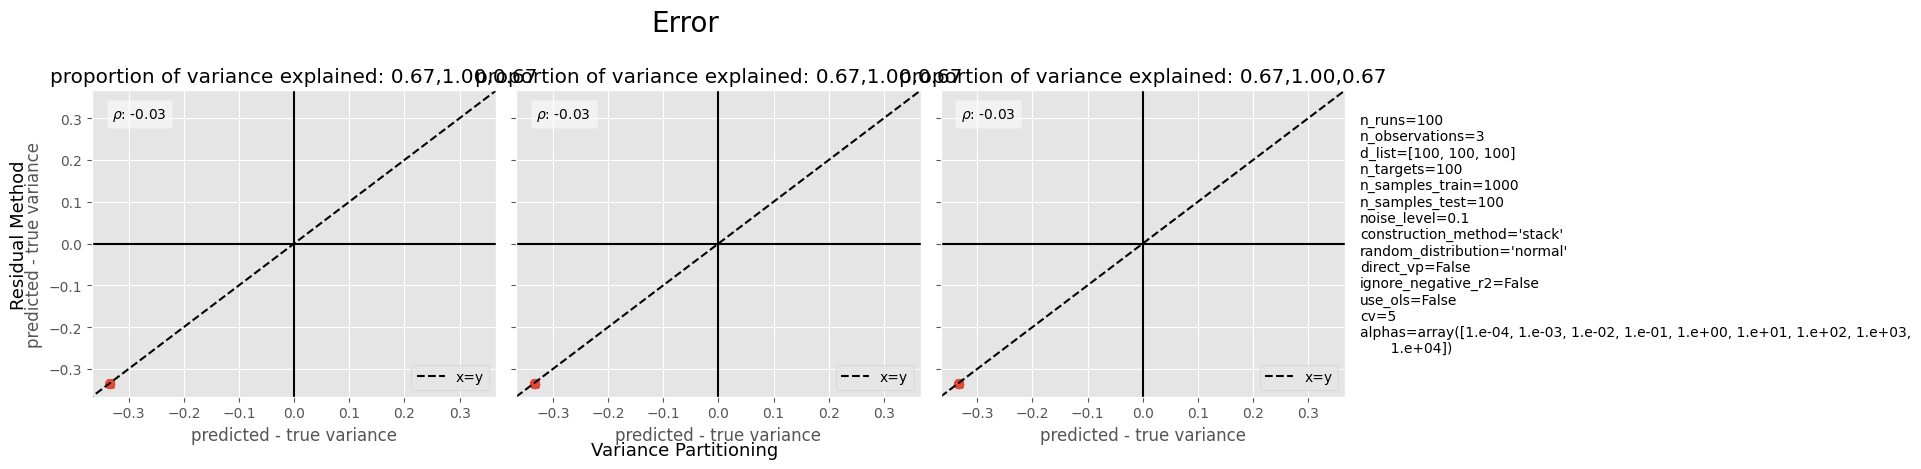

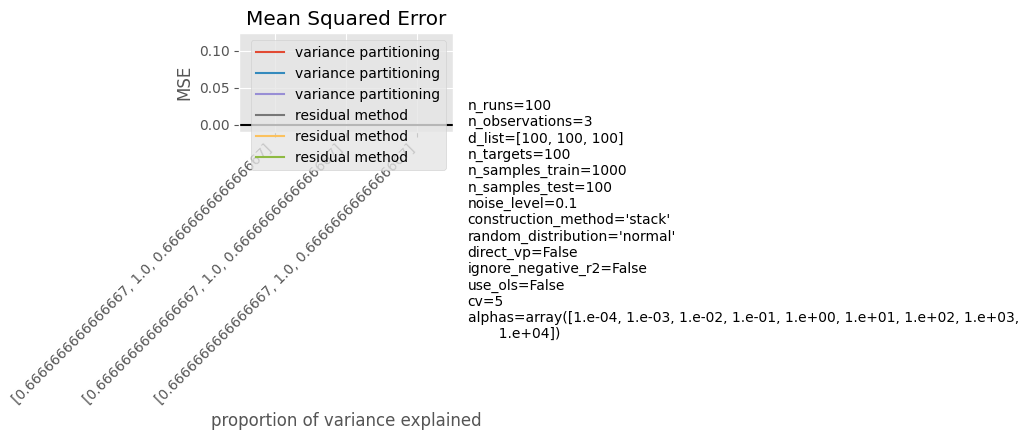

In [24]:
for unique_variance in unique_variances:
    remainders = 1 - unique_variance / len(variables["scalars"])
    # construct arrray of arrays, where the second entry is equal to unique_variance and the rest are equal to the remainder
    variances = [[remainders] * len(variables["scalars"])] * len(variables["scalars"])
    for i in range(len(variances[0])):
        variances[i][1] = unique_variance
    predicted_variance, predicted_residual = get_results(variable_name, variances, **variables)
    plot_experiment(variable_name, variances, predicted_variance, predicted_residual,
                    **variables)